In [3]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='01cb8ab3-b48d-441d-8d33-edc6caae425d', project_access_token='p-d36f9300425b2c63be8cd6c20d68a07ef91ec977')
pc = project.project_context


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.feature_selection import mutual_info_classif

In [5]:
product_col=['PRODUCT CODE','PRODUCT CATEGORY','UNIT LIST PRICE']
transactions_col=['CUSTOMER NUM','PRODUCT NUM','QUANTITY PURCHASED','DISCOUNT TAKEN','TRANSACTION DATE','STOCKOUT']

my_file = project.get_file("Product Data Set - Student 2 of 3.csv")
my_file.seek(0)
product_data=pd.read_csv(my_file,header=0,sep='|',usecols=product_col)

my_file = project.get_file("Transaction Data Set - Student 3 of 3.csv")
my_file.seek(0)
transactions_data=pd.read_csv(my_file,header=0,sep='|',usecols=transactions_col)

# Fetch the Customer file
my_file = project.get_file("Customer Data Set - Student 1 of 3.xlsx")
my_file.seek(0)
customer_data=pd.read_excel(my_file)



# perform checks on the input data for any null values

In [6]:
print('null values for transactoins ?',transactions_data.isnull().values.any())
print('null values for products ?',product_data.isnull().values.any())
print('null values for customers ?',customer_data.isnull().values.any())

null values for transactoins ? False
null values for products ? False
null values for customers ? True


# Check which columns have null values and why ?

In [7]:
customer_data.isnull()  # (it turned out that it is ENROLLMENT DATE of customers who are not enrolled yet into 
#Loyalty program ) , this column can be eliminated later since it is not important in the analysis

,CUSTOMER ID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False
5,False,False,False,False,False,False,True,False,False
6,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,True,False,False


In [8]:
product_data.shape

(30, 3)

In [9]:
transactions_data.shape

(10000, 6)

In [10]:
product_data.columns

Index(['PRODUCT CODE', 'PRODUCT CATEGORY', 'UNIT LIST PRICE'], dtype='object')

# collect and integrate data all together into a single view (transactional based)

In [11]:
partial_customer_TX_data=pd.merge(transactions_data,customer_data,how='left', left_on=['CUSTOMER NUM'], right_on=['CUSTOMER ID'])
drop_cols=['CUSTOMER ID','PRODUCT CODE']
full_customer_TX_data=pd.merge(partial_customer_TX_data,product_data,how='left',left_on=['PRODUCT NUM'],right_on=['PRODUCT CODE']).drop(drop_cols,axis=1)

In [12]:
full_customer_TX_data.shape

(10000, 16)

# perform checks on the final merged table for null values

In [13]:
full_customer_TX_data=full_customer_TX_data.drop('ENROLLMENT DATE',axis=1)  ### DO Not Run this CELL more than once O.W you will recalculate the full_customer_TX_data again
full_customer_TX_data.isnull().values.any()

False

In [14]:
full_customer_TX_data

,CUSTOMER NUM,PRODUCT NUM,QUANTITY PURCHASED,DISCOUNT TAKEN,TRANSACTION DATE,STOCKOUT,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,HOUSEHOLD SIZE,MARITAL STATUS,PRODUCT CATEGORY,UNIT LIST PRICE
0,10114,30011,4,0.0,1/2/2015,0,1,26,41777,10,not enrolled,1,Single,APPAREL,$25.46
1,10217,30016,3,0.0,1/2/2015,0,1,31,58025,1,not enrolled,6,Single,APPAREL,$29.31
2,10224,30013,4,0.0,1/2/2015,0,1,28,47145,2,not enrolled,2,Single,APPAREL,$26.85
3,10103,30012,3,0.2,1/2/2015,0,1,30,51978,7,not enrolled,4,Married,APPAREL,$28.51
4,10037,30010,8,0.0,1/2/2015,0,1,31,57724,9,not enrolled,3,Married,APPAREL,$25.27
5,10324,30010,7,0.0,1/2/2015,0,1,32,63075,5,not enrolled,4,Married,APPAREL,$25.27
6,10378,30012,8,0.0,1/2/2015,0,1,33,69329,6,not enrolled,6,Married,APPAREL,$28.51
7,10010,30015,8,0.2,1/2/2015,0,0,36,76994,2,not enrolled,2,Married,APPAREL,$29.63
8,10016,30010,5,0.0,1/2/2015,0,1,39,86025,3,not enrolled,2,Married,APPAREL,$25.27
9,10472,30014,7,0.0,1/2/2015,0,1,35,76751,3,not enrolled,4,Divorced,APPAREL,$26.71


# Now perform some aggregation functions and derive new features

# let's make the grouping based on the customers (customer NUM) and then derive multiple grouping funcitons

In [15]:
print(full_customer_TX_data.agg({'DISCOUNT TAKEN':'min'})) # this is a check on the values prior to define the following function
print(full_customer_TX_data.agg({'DISCOUNT TAKEN':'max'}))

DISCOUNT TAKEN    0.0
dtype: float64
DISCOUNT TAKEN    0.7
dtype: float64


# Construct new functions to derived features

In [16]:
def calculate_total_spending(unit_price,quantity,discount):
    total_spent=(1-discount)*float(unit_price.replace('$', ''))*quantity
    return total_spent

def calculate_pcntg_spent_to_income(INCOME,total_spent):
    pcntg = (total_spent/INCOME)*100
    return pcntg
 

In [17]:
full_customer_TX_data['sub_spent'] = full_customer_TX_data.apply(lambda row:calculate_total_spending(row['UNIT LIST PRICE'],row['QUANTITY PURCHASED'],row['DISCOUNT TAKEN']),axis=1)


In [18]:
customer_view = pd.DataFrame(full_customer_TX_data.groupby(['CUSTOMER NUM','GENDER','AGE','INCOME',\
                               'EXPERIENCE SCORE','LOYALTY GROUP','HOUSEHOLD SIZE','MARITAL STATUS'])\
.agg({'sub_spent':'sum','QUANTITY PURCHASED':'sum','CUSTOMER NUM':'count'})\
                             .rename(columns={'QUANTITY PURCHASED':'purchase_count','sub_spent':\
                                              'total_spent','CUSTOMER NUM':'tx_count'}).to_records())\
  # this flattened the output pivot table of the groupby and agg funcitons into a normal dataframe 
#with column  names equals to the names of the complex index of that pivot table.

In [19]:
customer_view['spent_pcntg_income'] = customer_view.apply(lambda row:calculate_pcntg_spent_to_income(row['INCOME'],row['total_spent']),axis=1)


# Let's do cross tabulation of each feature against the Loyalty Group attribute

In [20]:
customer_view.columns

Index(['CUSTOMER NUM', 'GENDER', 'AGE', 'INCOME', 'EXPERIENCE SCORE',
       'LOYALTY GROUP', 'HOUSEHOLD SIZE', 'MARITAL STATUS', 'purchase_count',
       'total_spent', 'tx_count', 'spent_pcntg_income'],
      dtype='object')

In [21]:
customer_view

,CUSTOMER NUM,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,HOUSEHOLD SIZE,MARITAL STATUS,purchase_count,total_spent,tx_count,spent_pcntg_income
0,10001,0,64,133498,5,enrolled,4,Single,396,6826.770,27,5.113762
1,10002,0,42,94475,9,not enrolled,6,Married,202,5062.451,24,5.358509
2,10003,0,40,88610,9,enrolled,5,Married,265,8562.440,23,9.663063
3,10004,0,38,84313,8,enrolled,1,Single,197,5522.694,19,6.550228
4,10005,0,30,51498,3,not enrolled,1,Single,12,213.512,2,0.414603
5,10006,1,63,132893,1,not enrolled,4,Married,309,5234.847,27,3.939144
6,10007,0,33,65002,9,enrolled,4,Married,139,5224.616,14,8.037623
7,10008,0,49,115672,9,enrolled,6,Single,265,8412.001,20,7.272288
8,10009,0,44,101741,9,enrolled,3,Married,273,9116.576,22,8.960572
9,10010,0,36,76994,2,not enrolled,2,Married,202,6620.147,25,8.598264


# Now lets derive some features with respect to product categories

In [22]:
product_stats = pd.DataFrame(full_customer_TX_data.groupby(['PRODUCT CATEGORY']).agg({'sub_spent':'sum','QUANTITY PURCHASED':'sum','DISCOUNT TAKEN':'mean'}).to_records()).rename(columns={'sub_spent':'total_spent','DISCOUNT TAKEN':'average_discount'})
product_view = pd.DataFrame(full_customer_TX_data.groupby(['PRODUCT CATEGORY','PRODUCT NUM']).agg({'sub_spent':'sum','QUANTITY PURCHASED':'sum','DISCOUNT TAKEN':'mean'}).to_records()).rename(columns={'sub_spent':'total_spent','DISCOUNT TAKEN':'average_discount'})

In [23]:
product_view.sort_values(['total_spent','QUANTITY PURCHASED'],ascending=False)

,PRODUCT CATEGORY,PRODUCT NUM,QUANTITY PURCHASED,total_spent,average_discount
9,ELECTRONICS,30019,5721,287032.326,0.063383
12,ELECTRONICS,30022,5294,271710.684,0.053772
10,ELECTRONICS,30020,5712,270412.876,0.067970
7,ELECTRONICS,30017,5645,267335.302,0.065677
8,ELECTRONICS,30018,5377,257041.100,0.072780
11,ELECTRONICS,30021,5065,253660.134,0.063485
5,APPAREL,30015,6526,179377.057,0.069552
2,APPAREL,30012,5376,142589.914,0.067130
6,APPAREL,30016,4953,135338.925,0.066049
1,APPAREL,30011,5244,124695.442,0.063918


# Let's generate here some visualization for the data to understand it.

# How Many males and females are enrolled in Loyalty

In [24]:
table= pd.crosstab(customer_view['GENDER'],customer_view['LOYALTY GROUP'])

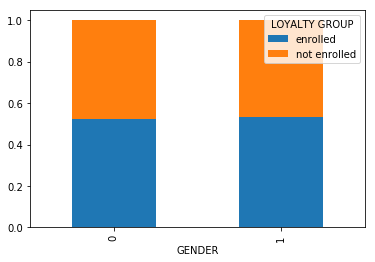

In [25]:
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.show()
# Comment: the Gender field is not a strong predictor as the class label is 50% split among each gender type

In [26]:
table

LOYALTY GROUP,enrolled,not enrolled
GENDER,,
0,131,120
1,133,116


# How many w.r.t.o marital status are enrolled into loyalty

In [27]:
table= pd.crosstab(customer_view['MARITAL STATUS'],customer_view['LOYALTY GROUP'])

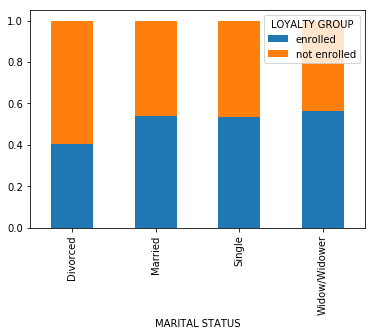

In [28]:
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.show()
#Comment: the Marital Status is not a strong predictor as the class labels are nearly half split among each state

In [29]:
table

LOYALTY GROUP,enrolled,not enrolled
MARITAL STATUS,,
Divorced,15,22
Married,144,123
Single,96,84
Widow/Widower,9,7


# Perform Binning of Age in the Customer View dataset

In [30]:
customer_view['AGE_BINNED'] = pd.cut(customer_view['AGE'],20) # 10 bins of age

In [31]:
customer_view

,CUSTOMER NUM,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,HOUSEHOLD SIZE,MARITAL STATUS,purchase_count,total_spent,tx_count,spent_pcntg_income,AGE_BINNED
0,10001,0,64,133498,5,enrolled,4,Single,396,6826.770,27,5.113762,"(61.2, 64.8]"
1,10002,0,42,94475,9,not enrolled,6,Married,202,5062.451,24,5.358509,"(39.6, 43.2]"
2,10003,0,40,88610,9,enrolled,5,Married,265,8562.440,23,9.663063,"(39.6, 43.2]"
3,10004,0,38,84313,8,enrolled,1,Single,197,5522.694,19,6.550228,"(36.0, 39.6]"
4,10005,0,30,51498,3,not enrolled,1,Single,12,213.512,2,0.414603,"(28.8, 32.4]"
5,10006,1,63,132893,1,not enrolled,4,Married,309,5234.847,27,3.939144,"(61.2, 64.8]"
6,10007,0,33,65002,9,enrolled,4,Married,139,5224.616,14,8.037623,"(32.4, 36.0]"
7,10008,0,49,115672,9,enrolled,6,Single,265,8412.001,20,7.272288,"(46.8, 50.4]"
8,10009,0,44,101741,9,enrolled,3,Married,273,9116.576,22,8.960572,"(43.2, 46.8]"
9,10010,0,36,76994,2,not enrolled,2,Married,202,6620.147,25,8.598264,"(32.4, 36.0]"


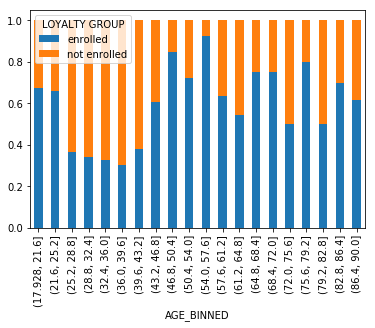

In [32]:
table= pd.crosstab(customer_view['AGE_BINNED'],customer_view['LOYALTY GROUP'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.show() 
### the figure below indicates that the Age could be a good contributor to classification

In [33]:
#customer_view['INCOME'].describe()
customer_view['INCOME_BINNED'] =pd.cut(customer_view['INCOME'],15)

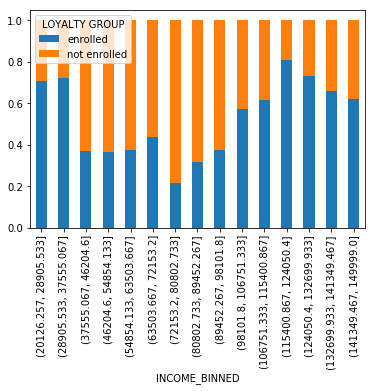

In [34]:
table= pd.crosstab(customer_view['INCOME_BINNED'],customer_view['LOYALTY GROUP'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.show() 
#the variation seen below i dicates that income could be a better contributor in classification

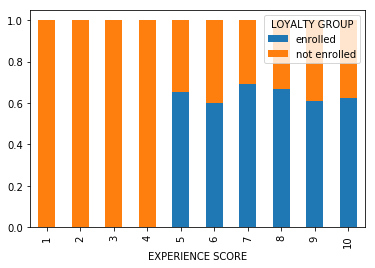

In [35]:
table= pd.crosstab(customer_view['EXPERIENCE SCORE'],customer_view['LOYALTY GROUP'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.show()

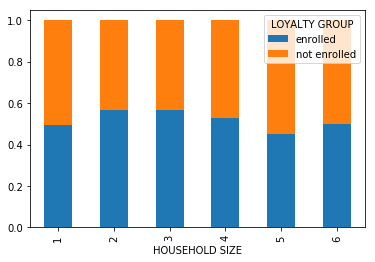

In [36]:
table= pd.crosstab(customer_view['HOUSEHOLD SIZE'],customer_view['LOYALTY GROUP'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.show()

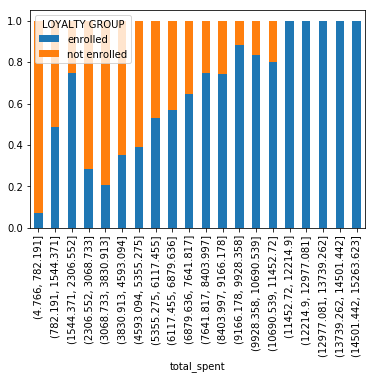

In [37]:
total_spent_binned=pd.cut(customer_view['total_spent'],20)
table= pd.crosstab(total_spent_binned,customer_view['LOYALTY GROUP'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.show()

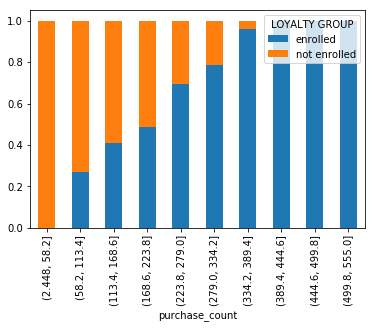

In [38]:
Purchase_count_binned=pd.cut(customer_view['purchase_count'],10)
table= pd.crosstab(Purchase_count_binned,customer_view['LOYALTY GROUP'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.show()

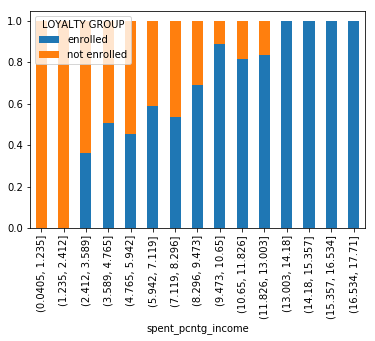

In [39]:
spent_pcntg_income_binned=pd.cut(customer_view['spent_pcntg_income'],15)
table= pd.crosstab(spent_pcntg_income_binned,customer_view['LOYALTY GROUP'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.show()

# Relation between Age and product category sales

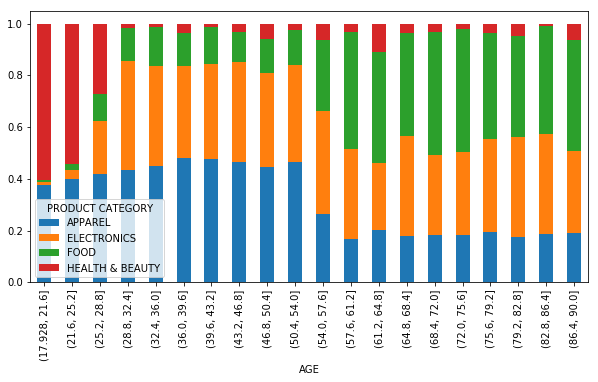

In [40]:
#full_customer_TX_data.groupby(['AGE','INCOME']).agg({'PRODUCT CATEGORY':'count'})
table= pd.crosstab(pd.cut(full_customer_TX_data['AGE'],20),full_customer_TX_data['PRODUCT CATEGORY'])

table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,figsize=(10,5))
plt.show() 

#there is deficiency in sales of health and beauty products among ages>25
#there is deficiency in sales of FOOD in ages between 18 years, 25 years

In [41]:
table

PRODUCT CATEGORY,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY
AGE,,,,
"(17.928, 21.6]",266,8,5,426
"(21.6, 25.2]",280,23,17,379
"(25.2, 28.8]",264,129,66,171
"(28.8, 32.4]",439,424,130,18
"(32.4, 36.0]",519,449,174,15
"(36.0, 39.6]",339,254,90,25
"(39.6, 43.2]",534,413,162,14
"(43.2, 46.8]",354,291,89,24
"(46.8, 50.4]",250,203,74,33


# Relation between income and product category sales

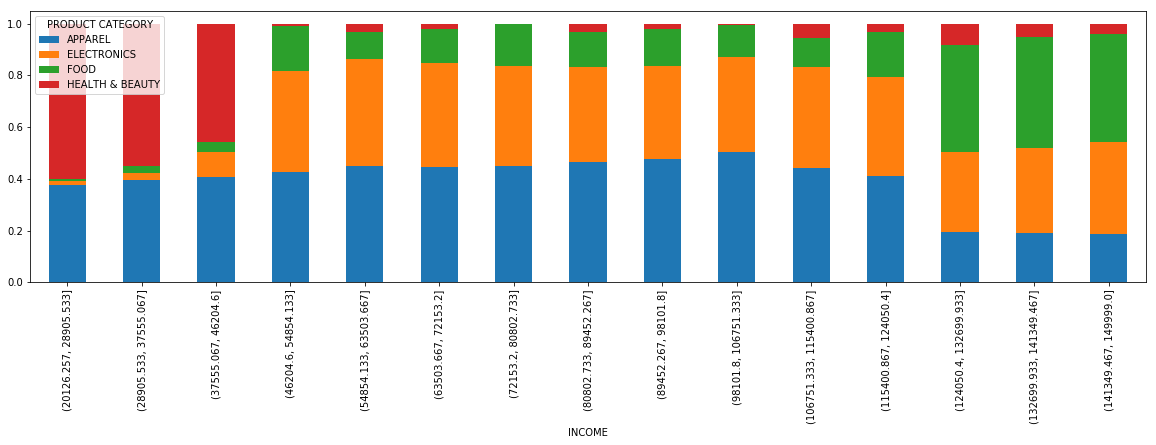

In [42]:
table= pd.crosstab(pd.cut(full_customer_TX_data['INCOME'],15),full_customer_TX_data['PRODUCT CATEGORY'])

table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,figsize=(20,5))
plt.show() 

#there is a deficiency in the sales of Electronics devices in Incomes between 20k-46K -> make discounts and more offers.

# Relation between marital status and product category sales

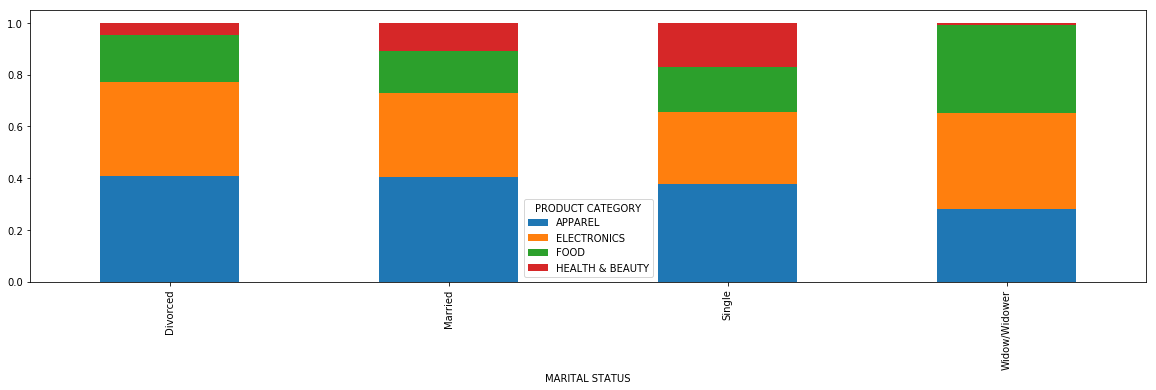

In [43]:
table= pd.crosstab(full_customer_TX_data['MARITAL STATUS'],full_customer_TX_data['PRODUCT CATEGORY'])

table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,figsize=(20,5))
plt.show() 


# check input data for balance against target field (see if data is balanced with class labels, we have 2 class labels, it is idealy that the input train data for classification is balanced w.r.t.o count of records for each class labels.)

In [44]:
customer_view['LOYALTY GROUP'].describe()
# the data is slightly biased toward the class label (enrolled) however, we will leave it as it is and not remove  those e
#any since the data amount is very small.

count          500
unique           2
top       enrolled
freq           264
Name: LOYALTY GROUP, dtype: object

# Perform classification of end users with respect to loyalty group using

In [45]:
drop_columns=['INCOME_BINNED','AGE_BINNED'] # drop the binned fields as their information gain is less than their unbinned parents
customer_view = customer_view.drop(drop_columns,axis=1)# drop the Customer ID as it is a useless column

# Calculate Entropy for input features with respect to class label

In [46]:
#mutual_info_classif
class_label=customer_view['LOYALTY GROUP']
cols=['GENDER','AGE','INCOME','EXPERIENCE SCORE','HOUSEHOLD SIZE','MARITAL STATUS','total_spent','purchase_count','tx_count','spent_pcntg_income']
input_fields=pd.get_dummies(customer_view[cols])
gain_list=mutual_info_classif(input_fields,class_label, discrete_features=False)


In [47]:
input_fields.columns

Index(['GENDER', 'AGE', 'INCOME', 'EXPERIENCE SCORE', 'HOUSEHOLD SIZE',
       'total_spent', 'purchase_count', 'tx_count', 'spent_pcntg_income',
       'MARITAL STATUS_Divorced', 'MARITAL STATUS_Married',
       'MARITAL STATUS_Single', 'MARITAL STATUS_Widow/Widower'],
      dtype='object')

In [48]:
list(gain_list)
a= list(range(0,len(gain_list)))
col1=[0,1,2,3,4,5,6,7,8,9]

In [49]:
gain_list.mean()

0.058740215847237327

In [50]:
gain_list

array([ 0.00685987,  0.04969502,  0.06862284,  0.12910143,  0.        ,
        0.12306398,  0.1710804 ,  0.04781971,  0.13605482,  0.        ,
        0.00616853,  0.00334607,  0.02181013])

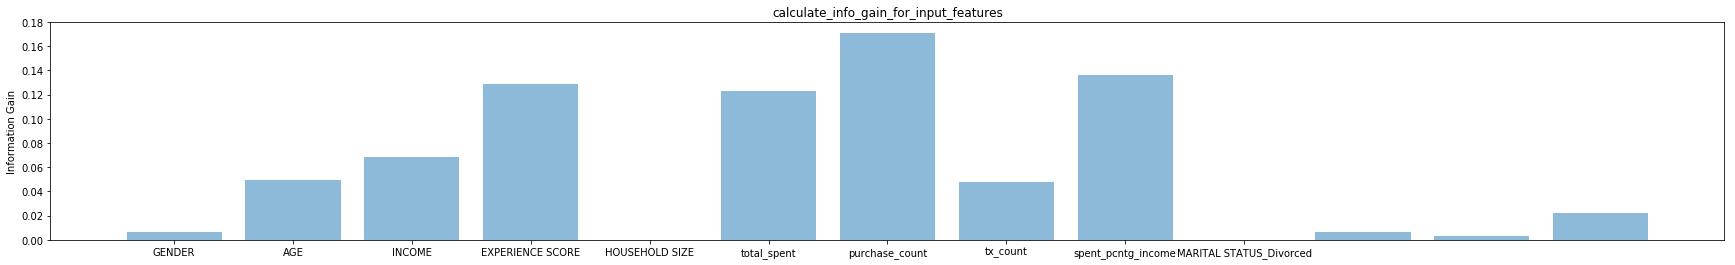

In [51]:
plt.xticks(col1,input_fields.columns,fontsize =10)
plt.ylabel('Information Gain')
plt.title('calculate_info_gain_for_input_features')
plt.bar(a,list(gain_list),align="center",alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(30, 4)
plt.show()



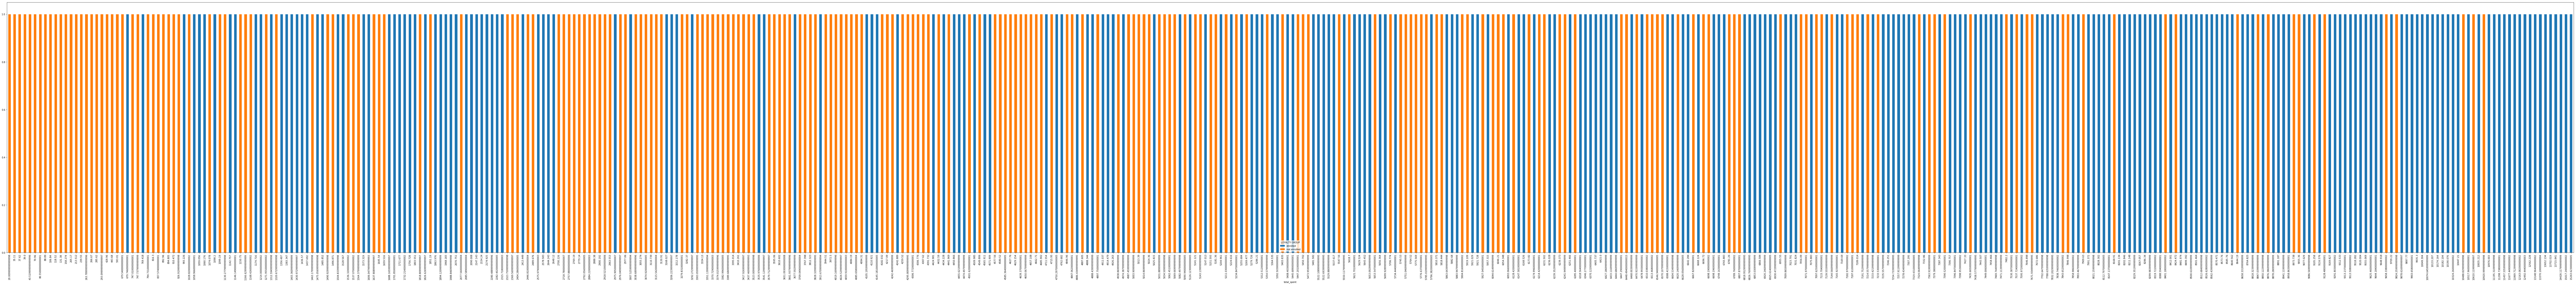

In [52]:
table= pd.crosstab(customer_view['total_spent'],customer_view['LOYALTY GROUP'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,figsize=(200,20))
plt.show() # the figure below confirms that the total_spent derived field has high info gain

# split the input data into train-test splits (80%-20% split)

In [53]:
#train, test = train_test_split(pd.get_dummies(customer_view), test_size=0.2)
cols=['INCOME','EXPERIENCE SCORE','LOYALTY GROUP','total_spent','purchase_count','tx_count','spent_pcntg_income']
train, test = train_test_split(customer_view[cols], test_size=0.2)

In [54]:
customer_view.columns

Index(['CUSTOMER NUM', 'GENDER', 'AGE', 'INCOME', 'EXPERIENCE SCORE',
       'LOYALTY GROUP', 'HOUSEHOLD SIZE', 'MARITAL STATUS', 'purchase_count',
       'total_spent', 'tx_count', 'spent_pcntg_income'],
      dtype='object')

In [55]:
train.columns

Index(['INCOME', 'EXPERIENCE SCORE', 'LOYALTY GROUP', 'total_spent',
       'purchase_count', 'tx_count', 'spent_pcntg_income'],
      dtype='object')

# separate the class labels from the test and train data

In [56]:
train_class_label=train[['LOYALTY GROUP']].values 
train_class_label = train_class_label.ravel()
train_features = train.drop('LOYALTY GROUP',axis=1)
test_class_label=test[['LOYALTY GROUP']].values
test_class_label = test_class_label.ravel()
test_features = test.drop('LOYALTY GROUP',axis=1)


In [57]:
pd.DataFrame(test_class_label).describe()


,0
count,100
unique,2
top,not enrolled
freq,51


# perform One Hot Encoding for categorical features and convert them into continious values

In [58]:
#train_features=pd.get_dummies(train_features)
#test_features=pd.get_dummies(test_features)

# Perform Normalization

In [59]:
type(train_class_label)

numpy.ndarray

In [60]:
X_train_np=preprocessing.minmax_scale(train_features)
X_test_np=preprocessing.minmax_scale(test_features)
#train_features=pd.DataFrame(X_train_np)
#test_features=pd.DataFrame(X_test_np)

In [61]:
train[['LOYALTY GROUP']].describe()

,LOYALTY GROUP
count,400
unique,2
top,enrolled
freq,215


# Classify using SVM 

In [62]:
clf = svm.SVC(kernel='rbf',max_iter=200)
% time clf.fit(X_train_np, train_class_label)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 28.2 ms


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=200, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [63]:
clf.score(X_test_np,test_class_label)

0.67000000000000004

In [64]:
clf_lin = svm.SVC(kernel='linear',max_iter=200)
% time clf_lin.fit(X_train_np, train_class_label)

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 39.9 ms


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=200, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [65]:
clf_lin.score(X_test_np,test_class_label)

0.77000000000000002

In [66]:
predicted_class_label=clf.predict(X_test_np)

In [67]:
cnf_mtrx=confusion_matrix(predicted_class_label,test_class_label,labels=['not enrolled','enrolled'])

In [68]:
len(predicted_class_label)

100

# Plotting Confusion Matrix

In [69]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[29  8]
 [15 48]]


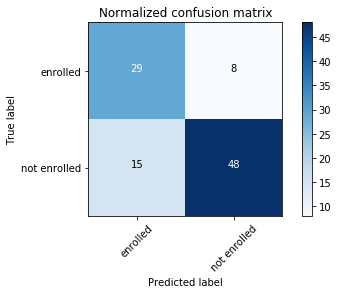

In [115]:
class_labels=['enrolled','not enrolled']
plot_confusion_matrix(cnf_mtrx, classes=class_labels, normalize=False,title='Normalized confusion matrix')

# Perform Segmentation for all customer base

# 1- Using KMeans

In [116]:
from sklearn.cluster import KMeans

# Transform encode categorical features and convert continious variables to Normal scale and 

In [117]:
cols=['INCOME','EXPERIENCE SCORE','HOUSEHOLD SIZE','total_spent',\
      'purchase_count', 'tx_count', 'spent_pcntg_income']
continious_cust_view = pd.get_dummies(customer_view[cols])
continious_cust_view=preprocessing.minmax_scale(continious_cust_view)

In [118]:
#new_derived_data_to_apply_clustering for
custo_product = pd.DataFrame(full_customer_TX_data.groupby(['CUSTOMER NUM','PRODUCT CATEGORY']).agg({'QUANTITY PURCHASED':'sum'}).to_records())
custo_product = pd.pivot_table(custo_product,values='QUANTITY PURCHASED',index='CUSTOMER NUM',columns='PRODUCT CATEGORY',aggfunc=np.sum).fillna(0)

# Loop to get the best number of clusters

In [119]:
#getting the best K 
# getting the K against the last abrubt change in the curve
cost_list=[]
for k in range(1,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(custo_product)
    cost_list.append(kmeans.inertia_)
diff_list=[]
for i in (range(0,len(cost_list)-1)):
    diff_list.append(cost_list[i+1]-cost_list[i])
    
    

In [120]:
cost_list

[4143289.3199999994,
 2797436.8486232627,
 1791366.1032010755,
 1325687.539477358,
 1154534.6922074175,
 1036541.9290928402,
 915050.287424861,
 824263.0948297834,
 763697.1082228092]

In [121]:
diff_list

[-1345852.4713767366,
 -1006070.7454221873,
 -465678.56372371735,
 -171152.84726994066,
 -117992.76311457728,
 -121491.64166797919,
 -90787.19259507756,
 -60565.98660697427]

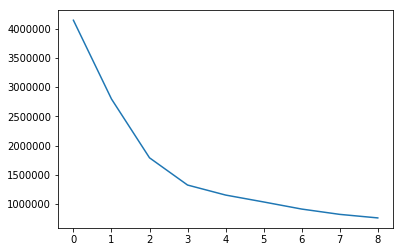

In [122]:
index = list(range(0,len(cost_list)))
plt.plot(index,cost_list)
plt.xticks(index)
plt.show()
#Best K from the diff_list is 3 and from the graph is 3 as at K=3 the graph experiences the last abrubt change.
#(elbow graph)


# segmenting the customers according to the best K

In [123]:
#Best K=3
kmeans = KMeans(n_clusters=3)
kmeans.fit(custo_product)
class_labels_kmeans=kmeans.predict(custo_product)

In [124]:

customer_view['customer_segment']=class_labels_kmeans

In [125]:
custo_product['customer_segment']=class_labels_kmeans

In [126]:
cluster_profile=custo_product.groupby('customer_segment').agg({'APPAREL':'mean', 'ELECTRONICS':'mean', 'FOOD':'mean','HEALTH & BEAUTY':'mean'})


In [127]:
cluster_profile

,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY
customer_segment,,,,
0,41.204545,5.916667,3.969697,54.325758
1,47.022222,103.000000,137.800000,10.566667
2,96.751799,81.881295,25.964029,2.697842


In [128]:
cluster_profile['FOOD']=preprocessing.minmax_scale(cluster_profile['FOOD'])
cluster_profile['ELECTRONICS']=preprocessing.minmax_scale(cluster_profile['ELECTRONICS'])
cluster_profile['HEALTH & BEAUTY']=preprocessing.minmax_scale(cluster_profile['HEALTH & BEAUTY'])
cluster_profile['APPAREL']=preprocessing.minmax_scale(cluster_profile['APPAREL'])


In [129]:
cluster_profile

,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY
customer_segment,,,,
0,0.000000,0.000000,0.000000,1.000000
1,0.104734,1.000000,1.000000,0.152414
2,1.000000,0.782468,0.164345,0.000000


In [130]:
#customer profiles:
#people who buy the same categories are grouped together as:
#0- Apparel and Electronics and Food Products and Health and Beauty
#1- Apparell and Electronics and Food Products
#2- Health and Beauty

In [131]:
customer_view.groupby(['customer_segment']).agg({'AGE':'count'})

,AGE
customer_segment,
0,132
1,90
2,278


In [132]:
#customer_view['GENDER']=customer_view['GENDER'].replace('Male',0).replace('Female',1)
customer_view.groupby(['customer_segment']).agg({'total_spent':'mean','AGE':'mean','INCOME':'mean','HOUSEHOLD SIZE':'mean','spent_pcntg_income':'mean','purchase_count':'mean','GENDER':'mean'})


,total_spent,AGE,INCOME,HOUSEHOLD SIZE,spent_pcntg_income,purchase_count,GENDER
customer_segment,,,,,,,
0,1700.825008,26.795455,45217.416667,2.181818,4.119866,105.416667,0.462121
1,6943.842456,68.922222,132780.155556,2.633333,5.285519,298.388889,0.577778
2,6637.829266,41.071942,89846.503597,3.316547,7.625865,207.294964,0.489209


In [133]:
customer_view[['AGE']].describe()

,AGE
count,500.000000
mean,42.316000
std,17.567509
min,18.000000
25%,30.000000
50%,39.000000
75%,50.250000
max,90.000000


In [134]:
customer_view[['INCOME']].describe()

,INCOME
count,500.000000
mean,85792.482000
std,37157.766304
min,20256.000000
25%,52429.000000
50%,86846.500000
75%,118381.000000
max,149999.000000


In [135]:
customer_view[['spent_pcntg_income']].describe()


,spent_pcntg_income
count,500.000000
mean,6.279019
std,2.807923
min,0.058128
25%,4.526334
50%,6.069121
75%,7.961431
max,17.710494


In [136]:
customer_view[['purchase_count']].describe()

,purchase_count
count,500.000000
mean,196.796000
std,96.740187
min,3.000000
25%,126.000000
50%,184.500000
75%,264.250000
max,555.000000


In [137]:
np.unique(customer_view[['MARITAL STATUS']].values)

array(['Divorced', 'Married', 'Single', 'Widow/Widower'], dtype=object)